In [1]:
#Ordinary Least Squares
from sklearn import linear_model
reg = linear_model.LinearRegression()
x = [[0,0],[1,1],[2,2]]
y = [0,1,2]
data = reg.fit(x,y)
print(reg.coef_)

[ 0.5  0.5]


In [11]:
#Ridge Regression
from sklearn import linear_model
reg = linear_model.Ridge(alpha = 0.5)
x = [[0,0],[0,0],[1,1]]
y = [0,0.1,1]
reg.fit(x, y)
print(reg.coef_)
print(reg.intercept_)

print("---------------")
#Setting the regularization parameter: generalized Cross-Validation
reg = linear_model.RidgeCV(alphas=[0.1,1,10])
reg.fit(x,y)
print(reg.alpha_)

[ 0.34545455  0.34545455]
0.136363636364
---------------
0.1


In [17]:
# Lasso
reg = linear_model.Lasso(alpha=0.1)
x = [[0,0],[1,1]]
y = [0,1]
reg.fit(x,y)
z = [[1,1]]
print(reg.predict(z))

##LARS Lasso
reg2 = linear_model.LassoLars(alpha=0.1)
x2 = [[0,0],[1,1]]
y2 = [0,1]
reg2.fit(x2,y2)
print(reg2.coef_)

[ 0.8]
[ 0.71715729  0.        ]


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.385982
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.240498


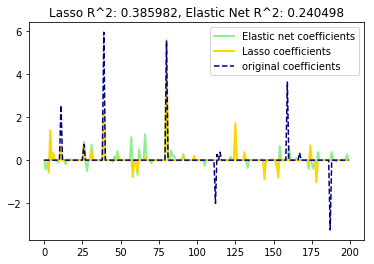

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

# #############################################################################
# Generate some sparse data to play with
np.random.seed(42)

n_samples, n_features = 50, 200
X = np.random.randn(n_samples, n_features)
coef = 3 * np.random.randn(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[10:]] = 0  # sparsify coef
y = np.dot(X, coef)

# add noise
y += 0.01 * np.random.normal(size=n_samples)

# Split data in train set and test set
n_samples = X.shape[0]
X_train, y_train = X[:n_samples // 2], y[:n_samples // 2]
X_test, y_test = X[n_samples // 2:], y[n_samples // 2:]

# #############################################################################
# Lasso
from sklearn.linear_model import Lasso

alpha = 0.1
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

# #############################################################################
# ElasticNet
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

plt.plot(enet.coef_, color='lightgreen', linewidth=2,
         label='Elastic net coefficients')
plt.plot(lasso.coef_, color='gold', linewidth=2,
         label='Lasso coefficients')
plt.plot(coef, '--', color='navy', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
          % (r2_score_lasso, r2_score_enet))
plt.show()

/home/liu/py3venv/lib/python3.5/site-packages/ipykernel_launcher.py:41: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


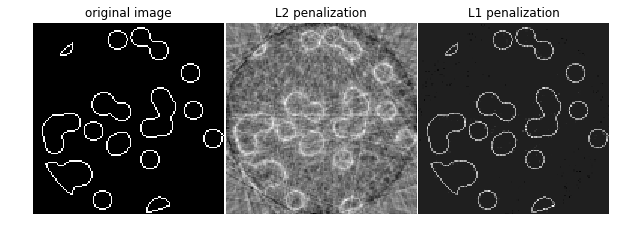

In [15]:
import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt


def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """ Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator


def generate_synthetic_data():
    """ Synthetic binary data """
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.) ** 2 + (y - l / 2.) ** 2 < (l / 2.) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))


# Generate synthetic images, and projections
l = 128
proj_operator = build_projection_operator(l, l / 7.)
data = generate_synthetic_data()
proj = proj_operator * data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('original image')
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L2 penalization')
plt.axis('off')
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L1 penalization')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)

plt.show()

In [19]:
# Bayesian Ridge Regression
x = [[0,0],[1,1],[2,2],[3,3]]
y = [0,1,2,3]
reg = linear_model.BayesianRidge()
reg.fit(x,y)
print(reg.predict([[1,0]]))
print(reg.coef_)

[ 0.50000013]
[ 0.49999993  0.49999993]


In [21]:
# Polynomial regression: extending linear models with basis functions
#[x1,x2] ----> [1, x1, x2, x1**2, x1*x2, x2**2]

from sklearn.preprocessing import PolynomialFeatures
x = np.arange(6).reshape(3,2)
print(x)
poly = PolynomialFeatures(degree=2)
print(poly.fit_transform(x))


[[0 1]
 [2 3]
 [4 5]]
[[  1.   0.   1.   0.   0.   1.]
 [  1.   2.   3.   4.   6.   9.]
 [  1.   4.   5.  16.  20.  25.]]


In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

model = Pipeline([('poly',PolynomialFeatures(degree=3)),
                   ('linear',LinearRegression(fit_intercept=False))])
x = np.arange(5)
y = 3 - 2*x + x**2 -x**3
model = model.fit(x[:,np.newaxis],y)
model.named_steps['linear'].coef_

array([ 3., -2.,  1., -1.])

In [27]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import PolynomialFeatures

x = np.array([[0,0],[0,1],[1,0],[1,1]])
y = x[:,0]^x[:,1]
print(y)
print("-------------------")
x = PolynomialFeatures(interaction_only=True).fit_transform(x).astype(int)
print(x)
print("-------------------")
clf = Perceptron(fit_intercept=False,max_iter=10,tol=None,
                 shuffle=False).fit(x,y)
print(clf.predict(x))
print("-------------------")
print(clf.score(x,y))

[0 1 1 0]
-------------------
[[1 0 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [1 1 1 1]]
-------------------
[0 1 1 0]
-------------------
1.0


In [14]:
from sklearn import datasets
boston = datasets.load_boston()

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
%matplotlib inline
# print(boston)

In [8]:
lr.fit(boston.data, boston.target)
predictions = lr.predict(boston.data)
# coefficients
lr.coef_

array([ -1.07170557e-01,   4.63952195e-02,   2.08602395e-02,
         2.68856140e+00,  -1.77957587e+01,   3.80475246e+00,
         7.51061703e-04,  -1.47575880e+00,   3.05655038e-01,
        -1.23293463e-02,  -9.53463555e-01,   9.39251272e-03,
        -5.25466633e-01])

In [10]:
lr2 = LinearRegression(normalize=True)
lr2.fit(boston.data,boston.target)
predictions2 = lr2.predict(boston.data)
lr2.coef_

array([ -1.07170557e-01,   4.63952195e-02,   2.08602395e-02,
         2.68856140e+00,  -1.77957587e+01,   3.80475246e+00,
         7.51061703e-04,  -1.47575880e+00,   3.05655038e-01,
        -1.23293463e-02,  -9.53463555e-01,   9.39251272e-03,
        -5.25466633e-01])

5.6169386226094877e-16

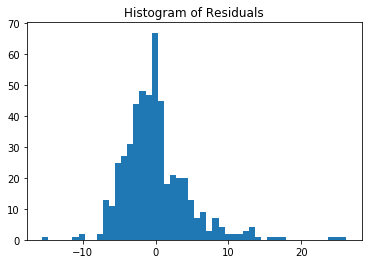

In [16]:
import matplotlib.pyplot as plt
import numpy as np
f = plt.figure()
ax = f.add_subplot(111)
ax.hist(boston.target - predictions, bins=50)
ax.set_title("Histogram of Residuals")
np.mean(boston.target - predictions)

((array([ -2.99573567e+00,  -2.71411028e+00,  -2.55577619e+00,
          -2.44351800e+00,  -2.35556494e+00,  -2.28276382e+00,
          -2.22036495e+00,  -2.16557440e+00,  -2.11660431e+00,
          -2.07223893e+00,  -2.03161265e+00,  -1.99408648e+00,
          -1.95917475e+00,  -1.92649942e+00,  -1.89576017e+00,
          -1.86671438e+00,  -1.83916307e+00,  -1.81294098e+00,
          -1.78790928e+00,  -1.76395019e+00,  -1.74096288e+00,
          -1.71886034e+00,  -1.69756695e+00,  -1.67701655e+00,
          -1.65715093e+00,  -1.63791855e+00,  -1.61927361e+00,
          -1.60117517e+00,  -1.58358651e+00,  -1.56647453e+00,
          -1.54980933e+00,  -1.53356377e+00,  -1.51771316e+00,
          -1.50223493e+00,  -1.48710847e+00,  -1.47231481e+00,
          -1.45783653e+00,  -1.44365756e+00,  -1.42976302e+00,
          -1.41613915e+00,  -1.40277318e+00,  -1.38965322e+00,
          -1.37676820e+00,  -1.36410778e+00,  -1.35166231e+00,
          -1.33942275e+00,  -1.32738062e+00,  -1.315527

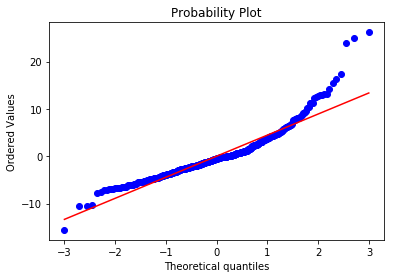

In [17]:
# Q-Q plot

from scipy.stats import probplot
f = plt.figure()
ax = f.add_subplot(111)
probplot(boston.target - predictions,plot=ax)

In [20]:
# mean squared error
def MSE(target, predictions):
    squared_deviation = np.power(target - predictions,2)
    return np.mean(squared_deviation)
MSE(boston.target,predictions)

21.8977792176875

In [21]:
#absolute deviation(MAD)
def MAD(target,predictions):
    absolute_deviation = np.abs(target - predictions)
    return np.mean(absolute_deviation)

MAD(boston.target,predictions)

3.2729446379969387

array([ 1.,  1.])

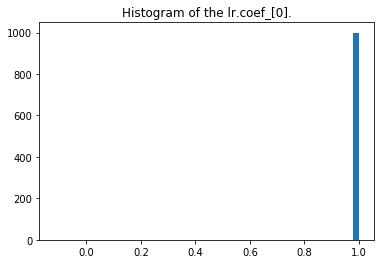

In [27]:
n_bootstraps = 1000
len_boston = len(boston.target)
subsample_size = np.int(0.5*len_boston)
subsample = lambda : np.random.choice(np.arange(0, len_boston),
                                      size=subsample_size)
coefs = np.ones(n_bootstraps)

for i in range(n_bootstraps):
    subsample_idx = subsample()
    subsample_x = boston.data[subsample_idx]
    subsample_y = boston.target[subsample_idx]
    
lr.fit(subsample_x, subsample_y)
coefs[i] = lr.coef_[0]

f = plt.figure()
ax = f.add_subplot(111)
ax.hist(coefs,bins=50)
ax.set_title("Histogram of the lr.coef_[0].")
np.percentile(coefs,[2.5,97.5])

In [28]:
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=2000,
                                       n_features=3, effective_rank=2, noise=10)
n_bootstraps = 1000
len_data = len(reg_data)
subsample_size = np.int(0.75*len_data)
subsample = lambda : np.random.choice(np.arange(0,len_data),
                                      size=subsample_size)
coefs = np.ones((n_bootstraps,3))

for i in range(n_bootstraps):
    subsample_idex = subsample()
    subsample_x = reg_data[subsample_idx]
    subsample_y = reg_target[subsample_idx]
    
lr.fit(subsample_x, subsample_y)

coefs[i][0] = lr.coef_[0]
coefs[i][1] = lr.coef_[1]
coefs[i][2] = lr.coef_[2]

In [34]:
#r = Ridge()
n_bootstraps = 1000
len_data = len(reg_data)
subsample_size = np.int(0.75*len_data)
subsample = lambda : np.random.choice(np.arange(0,len_data),
                                      size=subsample_size)
coefs_r = np.ones((n_bootstraps,3))
np.mean(coefs - coefs_r, axis=0)

np.var(coefs,axis=0)
np.var(coefs_r,axis=0)


array([ 0.,  0.,  0.])

In [41]:
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=100,
                                       n_features=2, effective_rank=1, noise=10)
from sklearn.linear_model import RidgeCV
rcv = RidgeCV(alphas=np.array([0.1,0.2,0.3,0.4]))
rcv.fit(reg_data,reg_target)

print(rcv.alpha_)

rcv2 = RidgeCV(alphas=np.array([0.08,0.09,0.1,0.11,0.12]))
rcv2.fit(reg_data, reg_target)
print(rcv2.alpha_)

alphas_to_test = np.linspace(0.01,1)
rcv3 = RidgeCV(alphas=alphas_to_test,store_cv_values=True)
rcv3.fit(reg_data, reg_target)
rcv3.cv_values_.shape #(100, 50)

smallest_idx = rcv3.cv_values_.mean(axis=0).argmin()
alphas_to_test[smallest_idx]
print(rcv3.alpha_)

0.1
0.08
0.01


In [42]:

def MAD(target, predictions):
    absolute_deviation = np.abs(target-predictions)
    return  absolute_deviation.mean()

import sklearn
MAD = sklearn.metrics.make_scorer(MAD,greater_is_better=False)
rcv4 = RidgeCV(alphas=alphas_to_test, store_cv_values=True,
               scoring=MAD)
rcv4.fit(reg_data,reg_target)
smallest_idx = rcv4.cv_values_.mean(axis=0).argmin()
alphas_to_test[smallest_idx]

0.37367346938775509

In [43]:
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=200,
                                       n_features=500, effective_rank=5, noise=5)
from sklearn.linear_model import Lasso
lasso = Lasso()

lasso.fit(reg_data,reg_target)
np.sum(lasso.coef_ != 0)
lasso_0 = Lasso(0)
lasso_0.fit(reg_data, reg_target)
np.sum(lasso_0.coef_ !=0)

/home/liu/py3venv/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # Remove the CWD from sys.path while we load stuff.
/home/liu/py3venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


500

In [44]:
from sklearn.linear_model import LassoCV
lassocv = LassoCV()
lassocv.fit(reg_data,reg_target)
lassocv.alpha_
print(lassocv.coef_[:5])
print(np.sum(lassocv.coef_ != 0))

mask = lassocv.coef_ != 0
new_reg_data = reg_data[:,mask]
print(new_reg_data.shape)

/home/liu/py3venv/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


array([-0.,  0., -0.,  0., -0.])

In [47]:
from sklearn.datasets import make_regression
reg_data, reg_target = make_regression(n_samples=200,
                                       n_features=500, effective_rank=10, noise=2)

from sklearn.linear_model import Lars
lars = Lars(n_nonzero_coefs=10)
lars.fit(reg_data,reg_target)
np.sum(lars.coef_ != 0)

train_n = 100
lars_12 = Lars(n_nonzero_coefs=12)
lars_12.fit(reg_data[:train_n],reg_target[:train_n])

lars_500 = Lars()
lars_500.fit(reg_data[:train_n],reg_target[:train_n])

np.mean(np.power(reg_target[train_n:] - lars_12.predict(reg_data[train_n:]),2))


6.7679272036169413

In [48]:
from sklearn.linear_model import LarsCV
lcv = LassoCV()
lcv.fit(reg_data, reg_target)
np.sum(lcv.coef_ != 0)

42